In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import albumentations as A
import os,shutil,cv2
from os import walk
import torch
from torchvision import datasets, transforms
from tqdm import tqdm

C:\Users\Arnav\anaconda3\envs\NN\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "Dataset/"
train_data_dir = "Dataset/Train/"
test_data_dir = "Dataset/Test/"

In [3]:
print('TRAINING SET:')
print('Healthy:', len(os.listdir(train_data_dir+'Healthy')))
print('Scab:', len(os.listdir(train_data_dir+'Scab')))

print('\nTESTING SET:')
print('Healthy:', len(os.listdir(test_data_dir+'Healthy')))
print('Scab:', len(os.listdir(test_data_dir+'Scab')))

TRAINING SET:
Healthy: 78
Scab: 191

TESTING SET:
Healthy: 12
Scab: 16


In [4]:
def show_data(path, label):
        fig, axs = plt.subplots(3, 4, figsize=(16, 12), constrained_layout=True)
        if label == 'healthy':
            files = os.listdir(f'{path}Healthy/')
            fig.suptitle('Healthy Apples\n', fontsize=18, fontweight='medium')
            idx = 0
            for i in range(3):
                for j in range(4):
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(f'{path}Healthy/{files[idx]}'), cv2.COLOR_BGR2RGB),(500, 500)))
                    axs[i][j].set_title(f'{files[idx]}', fontdict = {'fontsize':14, 'fontweight':'medium'})
                    axs[i][j].set_xticks(np.arange(0, 501, 100))
                    axs[i][j].set_yticks(np.arange(0, 501, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                    idx += 1
        elif label == 'scab':
            files = os.listdir(f'{path}Scab/')
            fig.suptitle('Scab Apples\n', fontsize=18, fontweight='medium')
            idx = 0
            for i in range(3):
                for j in range(4):
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(f'{path}Scab/{files[idx]}'), cv2.COLOR_BGR2RGB),(500, 500)))
                    axs[i][j].set_title(f'{files[idx]}', fontdict = {'fontsize':14, 'fontweight':'medium'})
                    axs[i][j].set_xticks(np.arange(0, 501, 100))
                    axs[i][j].set_yticks(np.arange(0, 501, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                    idx += 1
                        
        plt.savefig(f'{label}_apples', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 300)
        plt.show()

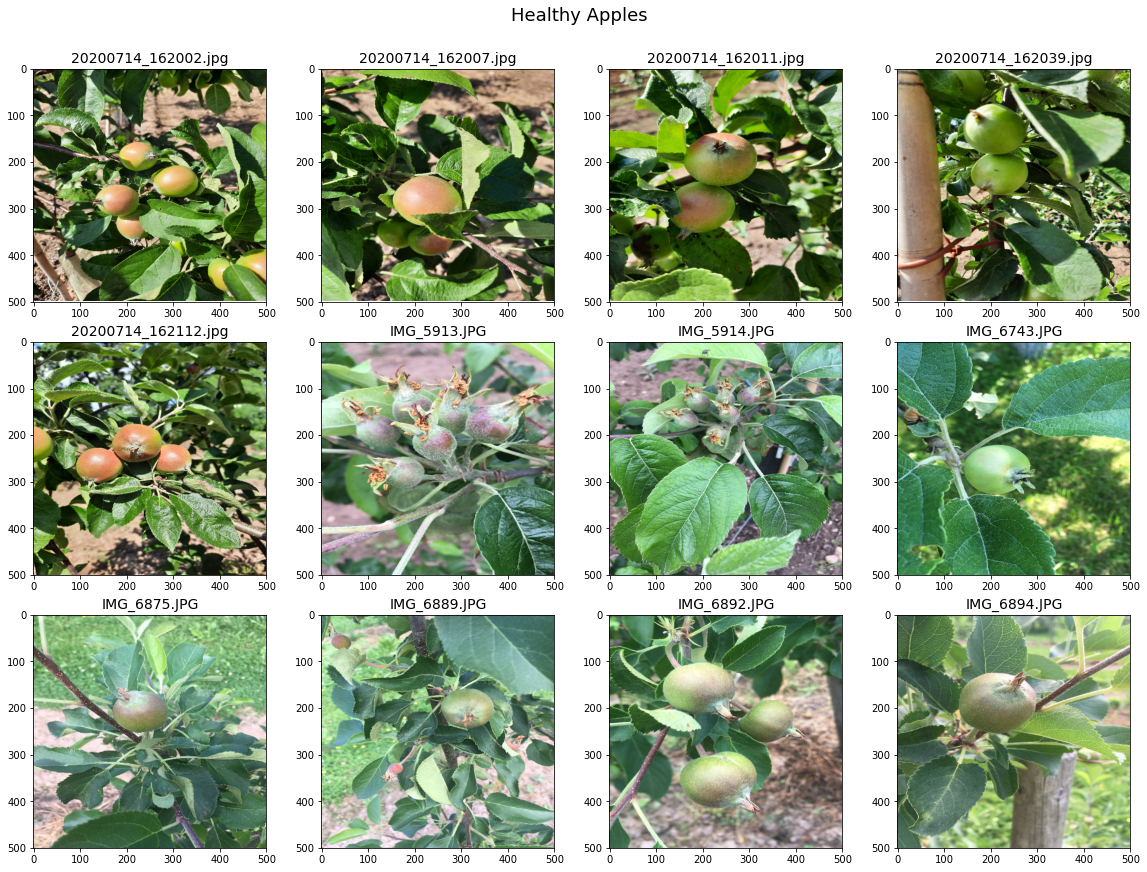

In [5]:
show_data(path=train_data_dir, label = 'healthy')

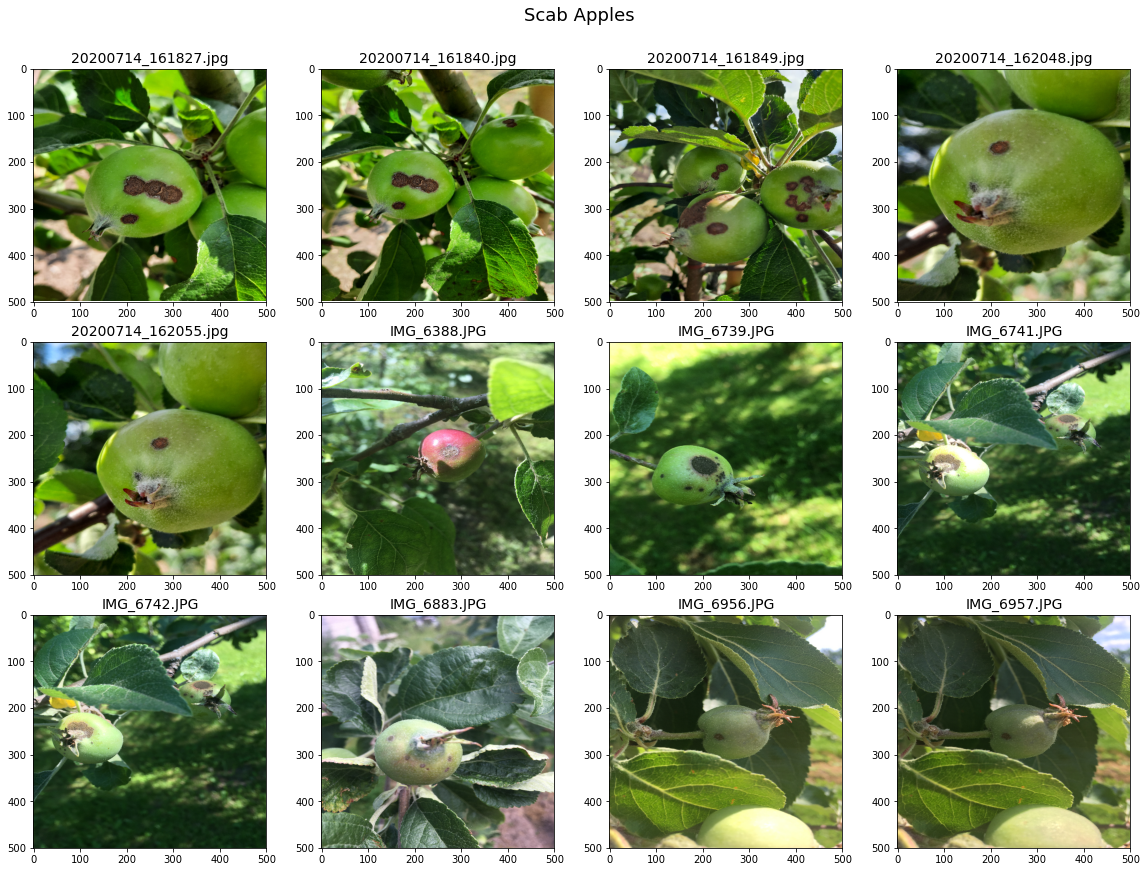

In [6]:
show_data(path=train_data_dir, label = 'scab')

There are only 297 images in the dataset (90 images in Healthy class and 207 images in Scab class). Out of which we have used 269 images (90%) for training set and remaining 28 images (10%) for test set.

Class-imbalance is present in the dataset, the Healthy class is under represented. There are only 78 images in the Healthy class, while the Scab class has 191 images. To minimize the extent of class-imbalance, artificial data augmentation has been applied on the images belonging to the Healthy class in the training set.

By data augmentation, the no. of images present in the Healthy class are increased from 78 to 156 (i.e. two times).

Data augmentation is done by the following techniques:

Random Cropping
Horizontal Flipping
Vertical Flipping
Rotation
Random Brightness & Contrast
Contrast Limited Adaptive Histogram Equalization (CLAHE)
Color Jitter

In [7]:
transform = A.Compose([
    A.RandomCrop(width=2400, height=2400, p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    A.Rotate(limit=[60, 240], p=1.0, interpolation=cv2.INTER_NEAREST),
    A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=0.75),
    A.OneOf([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.75),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.25)
    ], p=1.0),
], p=1.0)

In [25]:
os.chdir('Dataset/Train/')

In [27]:
!mkdir aug_healthy_images

In [32]:
healthy_images_files = os.listdir('Healthy')

In [33]:
def augment_dataset(files, path):
    i = 0
    for file in tqdm(files, desc="[Augmentation…]", ascii=False, ncols=75):
        img = cv2.imread(path+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transformed = transform(image=img)
        transformed_image = transformed['image']
        file_name = file.split('.')[0]
        cv2.imwrite(f'aug_healthy_images/AUG_{file_name}.JPG',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
        i += 1
    print('Data augmentation completed!')

In [35]:
augment_dataset(files=healthy_images_files, path= 'Healthy/')

[Augmentation…]: 100%|█████████████████████| 78/78 [00:23<00:00,  3.37it/s]

Data augmentation completed!


In [36]:
os.chdir('../../')

In [39]:
print('TRAINING SET:')
print('Healthy:', len(os.listdir(train_data_dir+'Healthy')))
print('Scab:', len(os.listdir(train_data_dir+'Scab')))
print('Augmented Healthy:', len(os.listdir(train_data_dir+'aug_healthy_images')))

print('\nTESTING SET:')
print('Healthy:', len(os.listdir(test_data_dir+'Healthy')))
print('Scab:', len(os.listdir(test_data_dir+'Scab')))

TRAINING SET:
Healthy: 78
Scab: 191
Augmented Healthy: 78

TESTING SET:
Healthy: 12
Scab: 16


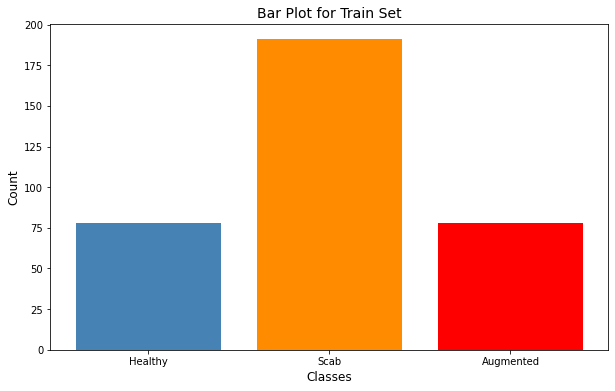

In [40]:
plt.figure(figsize=(10, 6))
data = {'Healthy': len(os.listdir(train_data_dir+'Healthy')), 'Scab': len(os.listdir(train_data_dir+'Scab')),'Augmented':  len(os.listdir(train_data_dir+'aug_healthy_images'))}
plt.bar(data.keys(), data.values(), color = ['steelblue', 'darkorange','red'])
plt.title('Bar Plot for Train Set', fontsize=14)
plt.xlabel("Classes", fontsize=12) 
plt.ylabel("Count", fontsize=12) 

plt.savefig('train_set_plot', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 300)